In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import joblib
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv(r"/kaggle/input/feature-common-language/audio_features_partial.csv")
df.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,label,file_path
0,0.712224,0.055740,2989.050985,2193.800068,5666.294643,0.275144,-202.32579,27.614292,4.094784,5.301181,...,4.752774,-0.985637,-6.752584,-4.679379,-5.478848,-0.866508,-1.919669,-0.634521,Arabic,/kaggle/input/preprocess-common-language/proce...
1,0.598403,0.074004,2372.315827,2065.561020,4795.649510,0.178041,-137.41476,59.931843,5.077963,-5.712012,...,-12.469353,-2.134825,-10.989368,-1.460541,-4.485021,-0.408789,-8.211143,-5.170048,Arabic,/kaggle/input/preprocess-common-language/proce...
2,0.756316,0.046051,3274.178654,2196.474265,5870.572917,0.353054,-233.02031,22.691550,10.057923,3.829097,...,-1.657243,-5.409642,-4.017134,-6.744406,-1.697630,-0.387302,0.829549,1.292110,Arabic,/kaggle/input/preprocess-common-language/proce...
3,0.588983,0.061376,1948.418292,2049.242741,4186.921296,0.137682,-199.04490,80.806870,31.451380,-1.297673,...,-4.202263,0.065943,-9.312079,-7.164060,-3.082040,-8.046175,-3.083879,-2.018449,Arabic,/kaggle/input/preprocess-common-language/proce...
4,0.647222,0.069638,1705.618989,1824.714129,3730.709877,0.095540,-325.47556,92.373820,17.725632,31.867613,...,3.169903,4.538502,-1.073114,-1.204524,-0.108214,-4.803460,-2.882802,-1.455632,Arabic,/kaggle/input/preprocess-common-language/proce...


In [4]:
df.duplicated().sum()

0

In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder with your actual labels
label_encoder.fit(df['label'])

# Transform actual labels to numeric labels
df['numeric_labels'] = label_encoder.transform(df['label'])

In [6]:
X = df.drop(columns=['label','numeric_labels','file_path'])
y = df['numeric_labels']

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [8]:
from collections import Counter

# Jumlah kelas sebelum SMOTE
print("Jumlah kelas sebelum SMOTE:")
print(Counter(y))

# Jumlah kelas setelah SMOTE
print("\nJumlah kelas setelah SMOTE:")
print(Counter(y_resampled))

Jumlah kelas sebelum SMOTE:
Counter({2: 3570, 39: 3177, 19: 3012, 6: 3003, 27: 2955, 41: 2784, 24: 2766, 0: 2751, 20: 2733, 37: 2691, 10: 2550, 33: 2547, 18: 2520, 21: 2484, 42: 2472, 8: 2442, 40: 2367, 26: 2331, 30: 2283, 28: 2277, 23: 2268, 32: 2238, 7: 2202, 31: 2196, 43: 2181, 15: 2073, 44: 2073, 5: 2016, 34: 1977, 9: 1962, 25: 1947, 12: 1932, 1: 1914, 16: 1890, 29: 1884, 14: 1863, 3: 1830, 17: 1830, 4: 1797, 11: 1773, 35: 1758, 36: 1752, 38: 1737, 22: 1695, 13: 1623})

Jumlah kelas setelah SMOTE:
Counter({0: 3570, 4: 3570, 9: 3570, 27: 3570, 18: 3570, 24: 3570, 23: 3570, 13: 3570, 20: 3570, 11: 3570, 16: 3570, 40: 3570, 28: 3570, 15: 3570, 21: 3570, 8: 3570, 31: 3570, 29: 3570, 5: 3570, 7: 3570, 41: 3570, 44: 3570, 3: 3570, 2: 3570, 14: 3570, 43: 3570, 36: 3570, 26: 3570, 34: 3570, 12: 3570, 37: 3570, 35: 3570, 42: 3570, 33: 3570, 17: 3570, 25: 3570, 6: 3570, 30: 3570, 39: 3570, 22: 3570, 10: 3570, 1: 3570, 19: 3570, 32: 3570, 38: 3570})


In [9]:
### split data 80% 20%

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42,
                                                    stratify=y_resampled)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1_l2

2024-07-04 01:39:34.034191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 01:39:34.034301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 01:39:34.148656: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

num_classes = len(label_encoder.classes_)
input_dim = X_train.shape[1]

# Reshape input untuk LSTM (batch_size, timesteps, features)
# Kita akan menganggap setiap fitur sebagai satu timestep
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential([
    Input(shape=(input_dim, 1)),
    
    LSTM(256, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import datetime


# Membuat callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,         
    restore_best_weights=True, 
    verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=0.000001, verbose=1)

model_checkpoint = ModelCheckpoint('best_model.keras', 
                                   save_best_only=True, 
                                   monitor='val_accuracy',
                                   mode='max', 
                                   verbose=1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, tensorboard_callback],
    verbose=1
)

Epoch 1/200
4015/4017 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0478 - loss: 3.9259
Epoch 1: val_accuracy improved from -inf to 0.12060, saving model to best_model.keras
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step - accuracy: 0.0478 - loss: 3.9257 - val_accuracy: 0.1206 - val_loss: 3.5000 - learning_rate: 0.0010
Epoch 2/200
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1176 - loss: 3.5020
Epoch 2: val_accuracy improved from 0.12060 to 0.16860, saving model to best_model.keras
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - accuracy: 0.1176 - loss: 3.5019 - val_accuracy: 0.1686 - val_loss: 3.3025 - learning_rate: 0.0010
Epoch 3/200
4016/4017 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1607 - loss: 3.3409
Epoch 3: val_accuracy improved from 0.16860 to 0.20330, saving model to best_model.keras
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - accuracy: 0.1607 - loss: 3.3409 - val_accuracy: 0.2033 - val_loss: 3.1503 - learning_rate: 0.0010
Epoch 4/200
4016/4017 ━━━━━━━━━

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.5f}")

Test accuracy: 0.56530


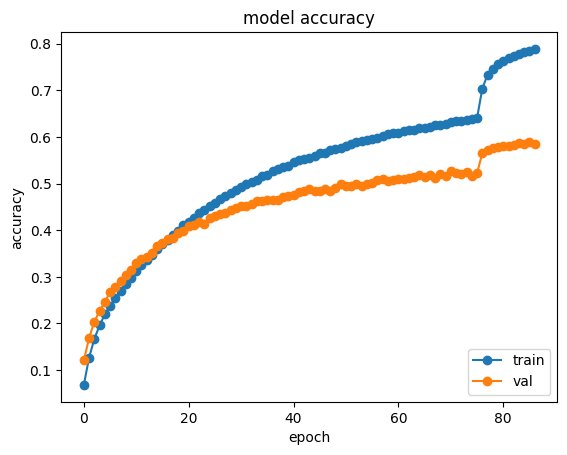

In [14]:
# Learning Curve
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()